# Peter-Weyl theorem on Brownian measure
 

In [1]:
import os
import torch
import torch.optim as optim
from torch import Tensor
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from tqdm import tqdm

os.chdir(os.path.join(os.getcwd(), ".."))
os.getcwd()

path_dir = os.path.join(os.getcwd(), "data", "paths")
if not os.path.exists(path_dir):
    os.mkdir(path_dir)

from development.nn import development_layer
from development.so import so

torch.cuda.is_available()

False

- DevNet did not work with cuda enabled from the setup.py installation

In [2]:
def generate_BM_paths(N: int, delta: float, rho: float, t: float = 1) -> np.ndarray:
    """
    Return N samples of 2D brownian motion with step-size delta and sample correlation rho
    """
    k = int(np.floor(t / delta))
    sigma = np.sqrt(delta)
    x = np.repeat(np.random.normal(scale=sigma, size=(1, k, 2)), N, axis=0)
    y = np.random.normal(scale=sigma, size=(N, k, 2))
    z = rho * x + np.sqrt(1 - rho**2) * y
    z = np.cumsum(z, axis=1)
    z = np.concatenate([np.zeros((N, 1, 2)), z], axis=1)
    return z


def generate_BM_paths_torch(
    N: int, delta: float, rho: float, t: float = 1, device: str = "cuda"
) -> Tensor:
    """
    Return N samples of 2D brownian motion with step-size delta and sample correlation rho
    """
    k = int(np.floor(t / delta))
    sigma = np.sqrt(delta)
    x = sigma * torch.randn((1, k, 2)).repeat(N, 1, 1)
    y = sigma * torch.randn((N, k, 2))
    z = rho * x + np.sqrt(1 - rho**2) * y
    z = torch.cumsum(z, axis=1)
    z = torch.cat([torch.zeros((N, 1, 2)), z], axis=1)
    return z

## Compute development


In [152]:
N = 100
delta = 1e-3
rho = 0.2

x = generate_BM_paths_torch(N, delta, rho)
x = torch.Tensor(x)

In [153]:
dev_layer = development_layer(
    input_size=2,
    hidden_size=10,
    channels=1,
    param=so,
    complexification=False,
    return_sequence=False,
)

In [154]:
X = dev_layer(x)
X.shape

torch.Size([100, 1, 10, 10])

In [11]:
nsamples = [100, 500, 1000, 2000]
delta = 1e-3
rho = 0.8

dev_layer = development_layer(
    input_size=2,
    hidden_size=10,
    channels=1,
    param=so,
    complexification=False,
    return_sequence=False,
)

tau_x = []

for i, N in tqdm(enumerate(nsamples)):
    x = generate_BM_paths(N, delta, rho)
    with open(os.path.join(path_dir, f"BM8_{i}.npy"), "wb+") as file:
        np.save(file, x)
    x = torch.Tensor(x)
    X = dev_layer(x)
    tau_x.append(torch.mean(X, axis=0)[0].detach())

4it [07:02, 105.56s/it]


In [13]:
diff = []
for i in range(len(nsamples) - 1):
    diff.append(tau_x[i + 1] - tau_x[i])

norm_diff = [np.linalg.norm(x) for x in diff]
norm_diff

[2.34649, 1.8908048, 2.0576282]

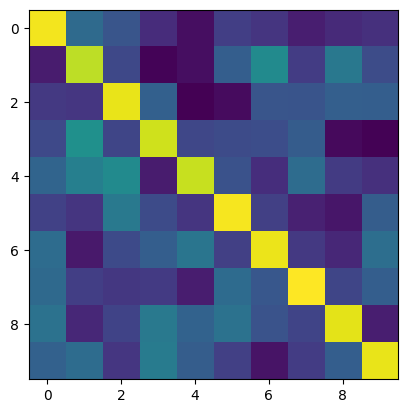

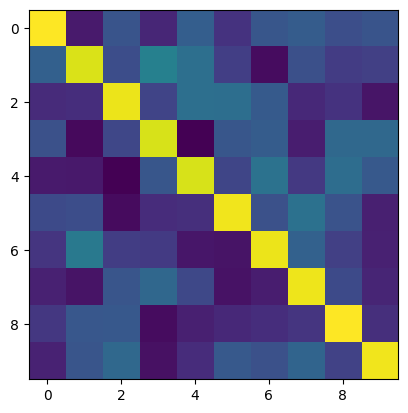

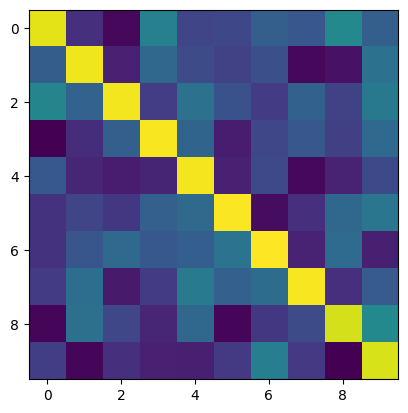

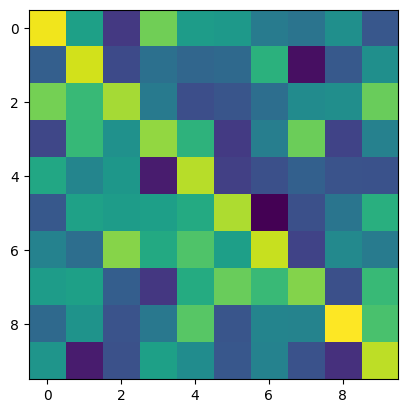

In [14]:
for tau in tau_x:
    plt.imshow(tau)
    plt.show()

## MC convergence
- show convergence rate
- compute confidence interval
- infer a closed form for the brownian motion : random matrix in the limit of dimensions ?
- Inverse of the Cayley map ? other way to sample the integral

In [183]:
Nx = np.logspace(1, 3, 10, endpoint=True, dtype=int)
ksamples = 10
tau_m = []
tau_v = []
for N in Nx:
    tau_kx = []
    # generate k times the same distribution
    for _ in range(ksamples):
        x = generate_BM_paths_torch(N, delta, rho)
        X = dev_layer(x)
        tau_x = torch.mean(X, axis=0)
        tau_kx.append(tau_x)
    # compute the MC estimate
    m = sum(tau_kx) / ksamples
    tau_m.append(m)

    # compute the sample  variance
    tau_v.append(sum([(t - m) ** 2 for t in tau_kx]))

RuntimeError: [enforce fail at ..\c10\core\CPUAllocator.cpp:79] data. DefaultCPUAllocator: not enough memory: you tried to allocate 2396000000 bytes.

In [186]:
norm_diff = [float(torch.norm(tau_m[k + 1] - tau_m[k])) for k in range(7)]
norm_diff_var = [float(torch.norm(tau_v[k + 1] - tau_v[k])) for k in range(7)]

([0.1752927601337433,
  0.14113059639930725,
  0.16160179674625397,
  0.1396259218454361,
  0.08232811838388443,
  0.0366213284432888,
  0.05550501123070717],
 [0.256348580121994,
  0.05772519111633301,
  0.07122337818145752,
  0.026767611503601074,
  0.012597094289958477,
  0.014435555785894394,
  0.007270270958542824])

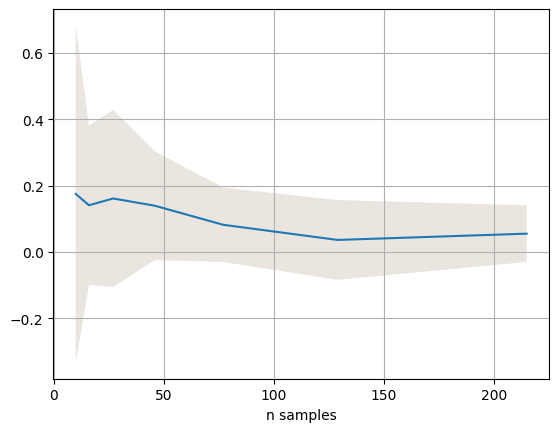

In [187]:
_, ax = plt.subplots()

ax.plot(Nx[:7], norm_diff)
ax.fill_between(
    Nx[:7],
    np.array(norm_diff) - np.sqrt(np.array(norm_diff_var)),
    np.array(norm_diff) + np.sqrt(np.array(norm_diff_var)),
    alpha=0.1,
)
ax.fill_between(
    Nx[:7],
    np.array(norm_diff) - np.sqrt(np.array(norm_diff_var)),
    np.array(norm_diff) + np.sqrt(np.array(norm_diff_var)),
    alpha=0.1,
)
ax.set_xlabel("n samples")
ax.grid()

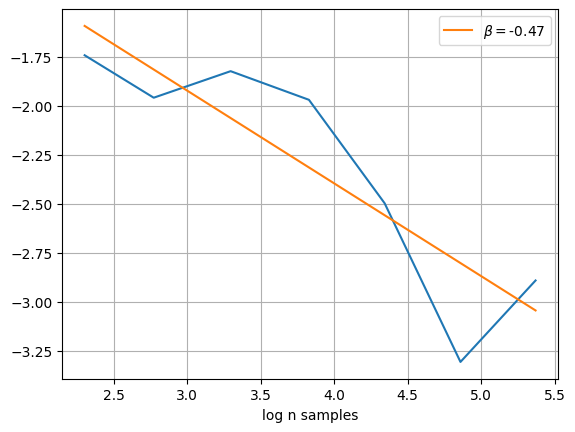

In [193]:
_, ax = plt.subplots()
norm_diff_log = np.log(norm_diff)
Nx = Nx[:7]
Nx_log = np.log(Nx)

# compute linear regression in log space
m = len(Nx)
X = np.ones((m, 2))
X[:, 1] = Nx_log
Y = np.array([norm_diff_log]).T
beta = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(Y)

ax.plot(Nx_log, norm_diff_log)
ax.plot(
    Nx_log,
    [beta[0] + beta[1] * x for x in np.log(Nx)],
    label=r"$\beta=$" + f"{np.round(beta[1][0], 2)}",
)

ax.set_xlabel("log n samples")
ax.legend()
ax.grid()

## Distinguish two distributions

In [64]:
N = 100
delta = 1e-4
rho = 0.0
eta = 0.3
trend = generate_BM_paths_torch(1, delta, rho)[0]
x = generate_BM_paths_torch(N, delta, rho)
y = np.sqrt(1 - eta**2) * generate_BM_paths_torch(N, delta, rho) + eta * trend

dev_layer = development_layer(
    input_size=2,
    hidden_size=10,
    channels=1,
    param=so,
    complexification=False,
    return_sequence=False,
)

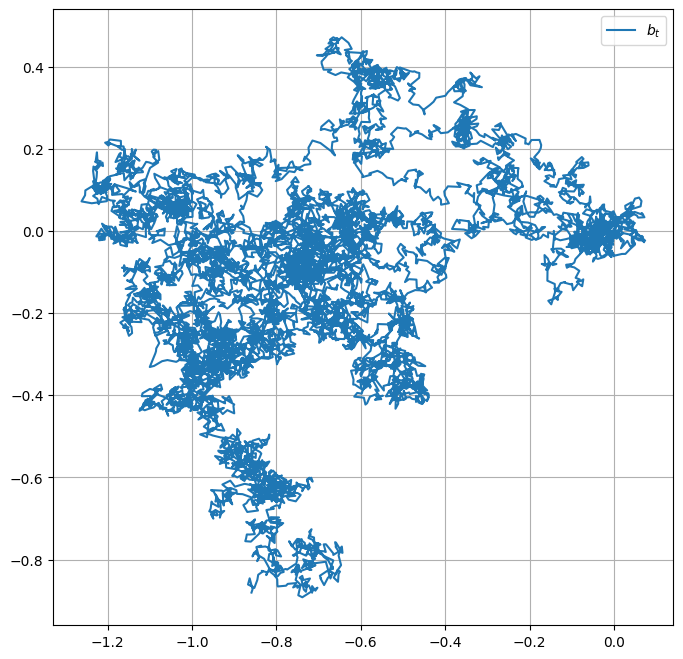

In [65]:
_, ax = plt.subplots(figsize=(8, 8))
ax.plot(trend[:, 0], trend[:, 1], label=r"$b_t$")
ax.grid()
ax.legend()

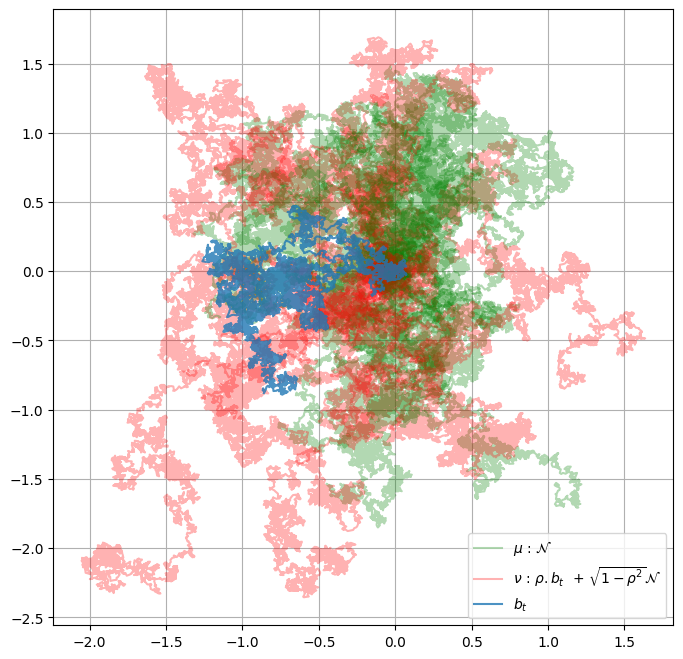

In [66]:
_, ax = plt.subplots(figsize=(8, 8))
nplot = 10
for i in range(nplot):
    ax.plot(x[i][:, 0].numpy(), x[i][:, 1].numpy(), alpha=0.3, c="green")
    ax.plot(y[i][:, 0].numpy(), y[i][:, 1].numpy(), alpha=0.3, c="red")
ax.plot(
    x[nplot + 1][:, 0].numpy(),
    x[i][:, 1].numpy(),
    alpha=0.3,
    c="green",
    label=r"$\mu$ : $\mathcal{N}$",
)
ax.plot(
    y[nplot + 1][:, 0].numpy(),
    y[i][:, 1].numpy(),
    alpha=0.3,
    c="red",
    label=r"$\nu$ : $\rho . b_t$  + $\sqrt{1-\rho^2}\mathcal{N}$",
)
ax.plot(trend[:, 0], trend[:, 1], label=r"$b_t$", alpha=0.8)
ax.grid()
ax.legend()

In [41]:
X = dev_layer(x)
Y = dev_layer(y)

In [42]:
tau_x = torch.mean(X, axis=0)
tau_y = torch.mean(Y, axis=0)

In [44]:
p = tau_x[0].T.matmul(tau_y[0])

In [76]:
n_mc = 100
tr_x = []
for _ in range(n_mc):
    x = generate_BM_paths_torch(N, delta, rho)
    y = generate_BM_paths_torch(N, delta, eta)
    X = dev_layer(x)
    Y = dev_layer(y)
    tau_x = torch.mean(X, axis=0)
    tau_y = torch.mean(Y, axis=0)
    p = tau_x[0].T.matmul(tau_y[0])
    tr_x.append(float(torch.trace(p)))

In [77]:
tr_x_test = []
for _ in range(n_mc):
    x = generate_BM_paths_torch(N, delta, rho)
    y = generate_BM_paths_torch(N, delta, rho)
    X = dev_layer(x)
    Y = dev_layer(y)
    tau_x = torch.mean(X, axis=0)
    tau_y = torch.mean(Y, axis=0)
    p = tau_x[0].T.matmul(tau_y[0])
    tr_x_test.append(float(torch.trace(p)))

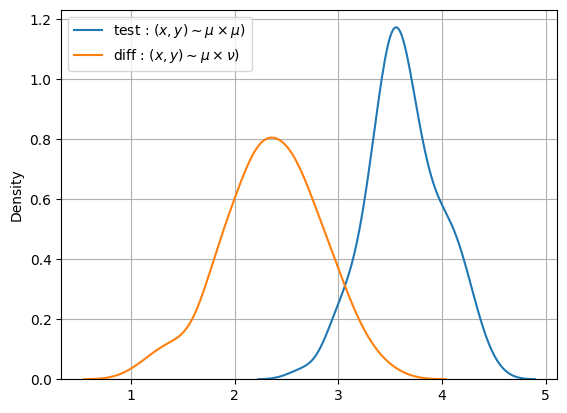

In [178]:
_, ax = plt.subplots()
sns.kdeplot(tr_x_test, ax=ax, label=r"test : $ (x,y) \sim \mu \times \mu$ ")
sns.kdeplot(tr_x, ax=ax, label=r"diff : $ (x,y) \sim \mu \times \nu$")
ax.legend()
ax.grid()

**optimise this result with backpropagation**

In [47]:
# construct the train set
N_same = 30
N_diff = 30
N = 100
delta = 1e-2
rho = 0.0
eta = 0.3
trend = generate_BM_paths_torch(1, delta, rho)[0]
train_same = torch.cat(
    [
        torch.cat(
            [
                generate_BM_paths_torch(N, delta, rho).unsqueeze(0),
                generate_BM_paths_torch(N, delta, rho).unsqueeze(0),
            ]
        ).unsqueeze(0)
        for _ in range(N_same)
    ]
)
train_diff = torch.cat(
    [
        torch.cat(
            [
                generate_BM_paths_torch(N, delta, rho).unsqueeze(0),
                (
                    np.sqrt(1 - eta**2) * generate_BM_paths_torch(N, delta, rho) + eta * trend
                ).unsqueeze(0),
            ]
        ).unsqueeze(0)
        for _ in range(N_same)
    ]
)

train = torch.cat([train_same, train_diff])
labels = Tensor([-1] * N_same + [1.0] * N_diff)

In [48]:
train.shape, labels.shape

(torch.Size([60, 2, 100, 101, 2]), torch.Size([60]))

In [49]:
dev_layer = development_layer(
    input_size=2,
    hidden_size=10,
    channels=1,
    param=so,
    complexification=False,
    return_sequence=False,
)

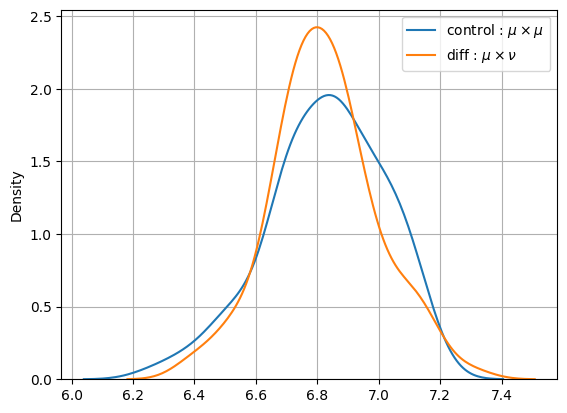

In [50]:
n_mc = 100
tr_x = []
trend = generate_BM_paths_torch(1, delta, rho)[0]
for _ in range(n_mc):
    x = generate_BM_paths_torch(N, delta, rho)
    y = np.sqrt(1 - eta**2) * generate_BM_paths_torch(N, delta, rho) + eta * trend
    X = dev_layer(x)
    Y = dev_layer(y)
    tau_x = torch.mean(X, axis=0)
    tau_y = torch.mean(Y, axis=0)
    p = tau_x[0].T.matmul(tau_y[0])
    tr_x.append(float(torch.trace(p)))

tr_x_test = []
for _ in range(n_mc):
    x = generate_BM_paths_torch(N, delta, rho)
    y = generate_BM_paths_torch(N, delta, rho)
    X = dev_layer(x)
    Y = dev_layer(y)
    tau_x = torch.mean(X, axis=0)
    tau_y = torch.mean(Y, axis=0)
    p = tau_x[0].T.matmul(tau_y[0])
    tr_x_test.append(float(torch.trace(p)))

_, ax = plt.subplots()
sns.kdeplot(tr_x_test, ax=ax, label=r"control : $ \mu\times\mu $ ")
sns.kdeplot(tr_x, ax=ax, label=r"diff : $ \mu \times \nu $")
ax.legend()
ax.grid()

In [51]:
# optimizer = optim.SGD(dev_layer.parameters(), lr=0.001, momentum=.9)
optimizer = optim.Adam(dev_layer.parameters(), lr=0.05)


def train_model(model, optimizer, data_loader, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in data_loader:
            optimizer.zero_grad()
            s = inputs.shape
            # Forward pass: compute the model output
            x, y = inputs[:, 0, ...], inputs[:, 1, ...]
            x = x.reshape((s[0] * s[2], s[3], s[4]))
            y = y.reshape((s[0] * s[2], s[3], s[4]))
            X = model(x)
            Y = model(y)
            d = X.shape[-1]
            X = X.reshape(s[0], s[2], d, d)
            Y = Y.reshape(s[0], s[2], d, d)
            tau_x = torch.mean(X, axis=1)
            tau_y = torch.mean(Y, axis=1)
            loss = (
                labels.dot(
                    (torch.swapaxes(tau_x, 1, 2).bmm(tau_y)).diagonal(dim1=1, dim2=2).sum(-1)
                )
                / s[0]
            )

            loss.backward()

            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(data_loader)}")


batch_size = 20

dataset = torch.utils.data.TensorDataset(train, labels)
data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Train the model for 5 epochs
train_model(dev_layer, optimizer, data_loader, num_epochs=10)

Epoch [1/10], Loss: 0.13353072355190912
Epoch [2/10], Loss: 0.0665227398276329
Epoch [3/10], Loss: 0.0704265038172404
Epoch [4/10], Loss: 0.07246183604001999
Epoch [5/10], Loss: 0.0631423791249593
Epoch [6/10], Loss: 0.037802815437316895
Epoch [7/10], Loss: 0.03376768777767817
Epoch [8/10], Loss: 0.028315110752979916
Epoch [9/10], Loss: 0.03548552996168534
Epoch [10/10], Loss: 0.04310405254364014


In [52]:
dev_layer.eval()

development_layer(
  (projection): projection(
    (param_map): so()
  )
)

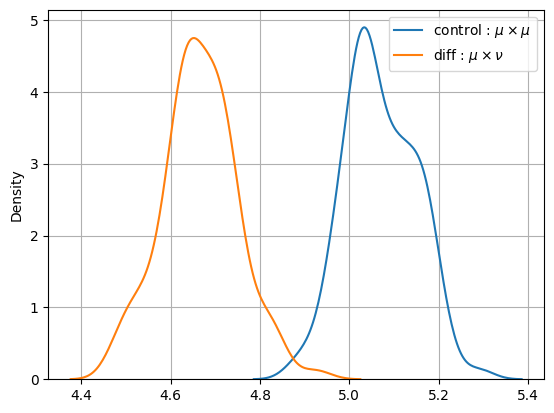

In [53]:
n_mc = 100
tr_x_test = []
for _ in range(n_mc):
    x = generate_BM_paths_torch(N, delta, rho)
    y = np.sqrt(1 - eta**2) * generate_BM_paths_torch(N, delta, rho) + eta * trend
    # y = generate_BM_paths_torch(N, delta, rho) + trend
    X = dev_layer(x)
    Y = dev_layer(y)
    tau_x = torch.mean(X, axis=0)
    tau_y = torch.mean(Y, axis=0)
    p = tau_x[0].T.matmul(tau_y[0])
    tr_x_test.append(float(torch.trace(p)))
tr_x = []
for _ in range(n_mc):
    x = generate_BM_paths_torch(N, delta, rho)
    y = generate_BM_paths_torch(N, delta, rho) + trend
    X = dev_layer(x)
    Y = dev_layer(y)
    tau_x = torch.mean(X, axis=0)
    tau_y = torch.mean(Y, axis=0)
    p = tau_x[0].T.matmul(tau_y[0])
    tr_x.append(float(torch.trace(p)))


_, ax = plt.subplots()
sns.kdeplot(tr_x_test, ax=ax, label=r"control : $ \mu\times\mu $ ")
sns.kdeplot(tr_x, ax=ax, label=r"diff : $ \mu \times \nu $")
ax.legend()
ax.grid()

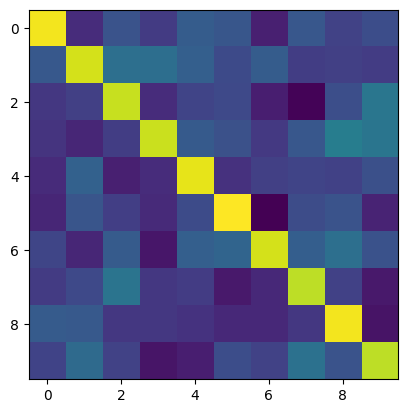

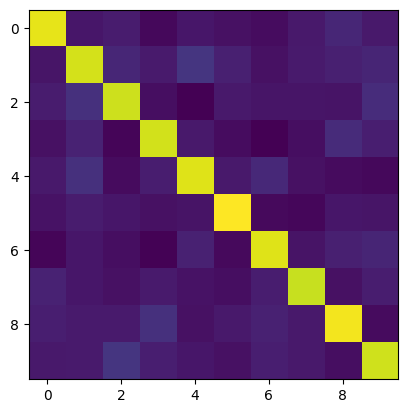

In [12]:
for tau in tau_y:
    plt.imshow(tau.detach())
    plt.show()

for tau in tau_x:
    plt.imshow(tau.detach())
    plt.show()

## Compare with the expected signature